<a href="https://colab.research.google.com/github/fwangliberty/AIoTDesign-Frontend/blob/master/transfervgg16_small2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We continue our efforts to train a new small VGG model from the original VGG16 model. The first CONV block and the last CONV layer will be used in our small joint model. We will use small middle CONV layers to see how the simplification impacts the accuracy.

# 1. Connecting to our Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/small/"

test  train  validation


#2. Prepare dataset

In [10]:
import keras
import os, shutil
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
import tensorflow.keras.backend as K
from keras.applications import VGG16

The directory where we will store our smaller dataset

In [11]:
base_dir = '/content/drive/My Drive/small'

 Directories for our smaller training and validation splits 

In [12]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

Build the train imagedatagenerator

In [13]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

Note that the validation data should not be augmented!

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 2000 images belonging to 2 classes.


In [16]:
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1000 images belonging to 2 classes.


In [17]:
test_generator = test_datagen.flow_from_directory(
         test_dir,
         target_size=(150, 150),
         batch_size=20,
         class_mode='binary')

Found 1000 images belonging to 2 classes.


# 3. Import VGG16 model

In [18]:
vgg16 = keras.applications.vgg16
conv_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
conv_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

We lock all the layers of the convolutional part:

In [19]:
for layer in conv_model.layers:
    layer.trainable = False

Reduce the number of filters in the last CONV block.

In [29]:
#x=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu',)(conv_model.layers[6].output)
x=tf.keras.layers.MaxPooling2D(2)(conv_model.layers[7].output)
x=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu',)(x)
x=tf.keras.layers.MaxPooling2D(2)(x)
x=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu',)(x)
x=tf.keras.layers.MaxPooling2D(2)(x)
x = tf.keras.layers.Flatten()(x)
# one dropout layer
x = keras.layers.Dropout(0.2)(x)
# one hidden layer
x = keras.layers.Dense(256, activation='relu')(x)
# final softmax layer with two categories (dog and cat)
predictions = keras.layers.Dense(1, activation='sigmoid')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)      

Now compile and train the model

In [30]:
full_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(lr=2e-5),
              #optimizer=keras.optimizers.Adamax(lr=0.001),
              metrics=['acc'])
			  
history = full_model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 21s 213ms/step - loss: 2.3622 - acc: 0.5100 - val_loss: 1.2837 - val_acc: 0.5750
Epoch 2/100
100/100 [==============================] - 22s 218ms/step - loss: 1.3271 - acc: 0.5705 - val_loss: 0.6469 - val_acc: 0.6720
Epoch 3/100
100/100 [==============================] - 21s 208ms/step - loss: 0.9669 - acc: 0.5995 - val_loss: 0.7262 - val_acc: 0.6610
Epoch 4/100
100/100 [==============================] - 21s 209ms/step - loss: 0.8361 - acc: 0.6180 - val_loss: 0.8208 - val_acc: 0.6050
Epoch 5/100
100/100 [==============================] - 21s 207ms/step - loss: 0.7703 - acc: 0.6325 - val_loss: 0.6722 - val_acc: 0.6350
Epoch 6/100
100/100 [==============================] - 21s 210ms/step - loss: 0.7203 - acc: 0.6400 - val_loss: 0.5151 - val_acc: 0.7370
Epoch 7/100
100/100 [==============================] - 21s 212ms/step - loss: 0.6715 - acc: 0.6555 - val_loss: 0.5196 - val_acc: 0.7270
Epoch 8/100
100/100 [===========================

In [23]:
full_model.save('cats_and_dogs_full_small2.h5')

In [24]:
from google.colab import files
files.download("cats_and_dogs_full_small2.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
print("Evaluate the full model on small test data")
results = full_model.evaluate(test_generator)
print("test loss, test acc:", results)

Evaluate the full model on small test data
50/50 [==============================] - 4s 75ms/step - loss: 0.4851 - acc: 0.8000
test loss, test acc: [0.48508360981941223, 0.800000011920929]


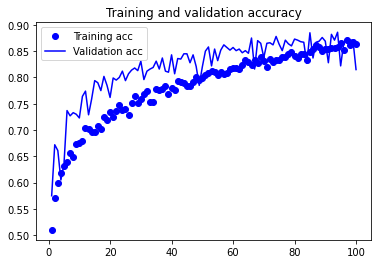

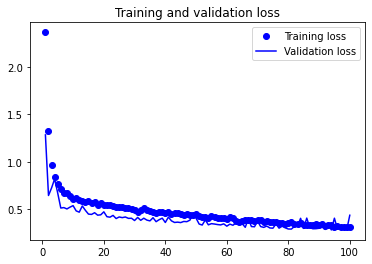

In [32]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()